In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [3]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.io import fits

In [4]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)
color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [5]:
X = np.loadtxt('./20jgb_phot/SN2020jgb_ZTF_g_snr2.dat')
Y = np.loadtxt('./20jgb_phot/SN2020jgb_ZTF_r_snr2.dat')

tfo = min(X[np.argwhere(X[:, -1] > 0)[0], 0], Y[np.argwhere(Y[:, -1] > 0)[0],
                                                0])[0]
tno = max(X[np.argwhere(X[:, -1] > 0)[0] - 1, 0],
          Y[np.argwhere(Y[:, -1] > 0)[0] - 1, 0])[0]
tfl = (tfo + tno) / 2
tfl_unc = (tfo - tno) / 2
print(tfl, tfl_unc)

58969.470214999994 2.992744999999559


In [6]:
tp = 58986.41
z = 0.0307

## g-r

In [7]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    mag1, mag2 = X[:, 1], Y[:, 1]
    if not flux:
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        unc1, unc2 = X[:, 3:], Y[:, 3:]
        f1, f2 = 10**(-0.4 * mag1), 10**(-0.4 * mag2)
        f_unc1 = (10**(-0.4 *
                       (mag1 - unc1[:, 0])) - 10**(-0.4 *
                                                   (mag1 + unc1[:, 1]))) / 2
        f_unc2 = (10**(-0.4 *
                       (mag2 - unc2[:, 0])) - 10**(-0.4 *
                                                   (mag2 + unc2[:, 1]))) / 2
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [8]:
# From Bulla, Miller+2020

gr_population = pd.read_csv('color/g_r_Bulla20.txt', 
                            delim_whitespace=True, comment='#',
                            names=['SN', 't', 'e_t_min', 'e_t_max', 
                                   'gr', 'e_gr_min', 'e_gr_max',
                                   'type', 'marker'])

normal_ia = np.where((gr_population.type == 'normal*') |
                     (gr_population.type == 'normal') | 
                     (gr_population.type == '91T-like') |
                     (gr_population.type == '99aa-like') | 
                     (gr_population.type == '99aa-like*')
                    )

print('There are {} normal SNe in this sample'.format(len(gr_population.iloc[normal_ia].SN.unique())))

gr_population.head(5)

There are 62 normal SNe in this sample


,SN,t,e_t_min,e_t_max,gr,e_gr_min,e_gr_max,type,marker
0,ZTF18aapqwyv,2.111188,0.685375,0.529521,0.242970,0.368273,0.384782,normal*,o
1,ZTF18aapqwyv,3.032216,0.685375,0.529521,0.945111,0.297778,0.358075,normal*,o
2,ZTF18aapqwyv,3.974450,0.685375,0.529521,0.270548,0.168496,0.161108,normal*,o
3,ZTF18aapqwyv,4.973797,0.685375,0.529521,0.125119,0.193820,0.177315,normal*,o
4,ZTF18aapqwyv,16.227165,0.685375,0.529521,-0.131547,0.033107,0.033027,normal*,o


## Figure 2

In [9]:
# 11fe
distmod = 29.04 #\pm 0.19
fe_g_syn = np.loadtxt('./synthetic_phot/SN2011fe_g_synthetic.dat')
fe_g_syn[:, 0] = (fe_g_syn[:, 0] - 55816.6) / (1 + 0.0008) # w.r.t r peak
fe_g_syn[:, 1] = fe_g_syn[:, 1] - distmod
fe_r_syn = np.loadtxt('./synthetic_phot/SN2011fe_r_synthetic.dat')
fe_r_syn[:, 0] = (fe_r_syn[:, 0] - 55816.6) / (1 + 0.0008) # w.r.t r peak
fe_r_syn[:, 1] = fe_r_syn[:, 1] - distmod
fe_g_r_syn = np.loadtxt('./synthetic_phot/SN2011fe_g_r_synthetic.dat')
fe_g_r_syn[:, 0] = (fe_g_r_syn[:, 0] - 55796.687) / (1 + 0.0008) # w.r.t fl

In [10]:
# 16jhr
jhr_lc = Table.read('./other_Ia_pec/16jhr.csv')
jhr_lc = jhr_lc[~np.isnan(jhr_lc['e_magnitude'])]
jhr_lc['Phase'] = (jhr_lc['time'] - 57504) / (1 + 0.11737)
jhr_lc['Phase_fl'] = (jhr_lc['time'] - 57482) / (1 + 0.11737)
jhr_lc = jhr_lc[~jhr_lc['e_magnitude'].mask]

jhr_g = jhr_lc[(jhr_lc['band'] == 'g')]
jhr_r = jhr_lc[(jhr_lc['band'] == 'r')]

distmod = 38.69 # Jiang+2017, method part

leff_g = 4816.12  #AA
leff_r = 6234.11  #AA
rv = 3.1
ebv = 0.0263

jhr_g['Mag'] = jhr_g['magnitude'] - distmod - calALambda(leff_g, rv, ebv)
jhr_r['Mag'] = jhr_r['magnitude'] - distmod - calALambda(leff_r, rv, ebv)

X = np.array([jhr_g['Phase'], jhr_g['Mag'], jhr_g['e_magnitude']]).T
Y = np.array([jhr_r['Phase'], jhr_r['Mag'], jhr_r['e_magnitude']]).T
jhr_g_bin = data_binning(X, size=0.5)
jhr_r_bin = data_binning(Y, size=0.5)

X = np.array([jhr_g['Phase_fl'], jhr_g['Mag'], jhr_g['e_magnitude']]).T
Y = np.array([jhr_r['Phase_fl'], jhr_r['Mag'], jhr_r['e_magnitude']]).T
X = data_binning(X, size=1)
Y = data_binning(Y, size=1)
dT_jhr, dmag_jhr, Unc_jhr = mag1_mag2(X, Y, bin_size=1)
dmag_jhr = dmag_jhr[dT_jhr > 1]
Unc_jhr = Unc_jhr[dT_jhr > 1]
dT_jhr = dT_jhr[dT_jhr > 1]

In [11]:
# 18byg
byg_lc = Table.read('./other_Ia_pec/18byg.txt', format='ascii')
byg_lc = byg_lc[~np.isnan(byg_lc['e_omag'])]
byg_r = byg_lc[byg_lc['Filter'] == 'r']
byg_g = byg_lc[byg_lc['Filter'] == 'g']

z_byg = 0.066

DL = np.loadtxt('./ipac_distmod/18byg_peculiar.dat')[6]  #H0 = 70
distmod = 5 * np.log10(DL * 1e6 / 10) * u.mag

leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.011

byg_g['Mag'] = byg_g['omag'] - distmod.value - calALambda(leff_g, rv, ebv)
byg_r['Mag'] = byg_r['omag'] - distmod.value - calALambda(leff_r, rv, ebv)

tfl_byg = 58233.198 + 9.07 / 2

#photometry
X = np.array([(byg_g['MJD'] - tfl_byg) / (1 + z_byg), byg_g['Mag'],
              byg_g['e_omag']]).T
Y = np.array([(byg_r['MJD'] - tfl_byg) / (1 + z_byg), byg_r['Mag'],
              byg_r['e_omag']]).T
dT_byg, dmag_byg, Unc_byg = mag1_mag2(X, Y, bin_size=1)

#synthetic
color_byg = Table.read('color/gr_18byg.txt', format='ascii')
gr_byg = color_byg[color_byg['Filt'] == 'gr']
tp_byg = byg_r['MJD'][np.argmin(byg_r['omag'])]
gr_byg['Phase'] = (gr_byg['Epoch'] + tp_byg - tfl_byg) / (1 + 0.066)
dT_byg = np.append(dT_byg, gr_byg['Phase'])
dmag_byg = np.append(dmag_byg, gr_byg['Color'])
Unc_byg = np.append(Unc_byg, gr_byg['Err'])

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_91156/845862577.py:48: RuntimeWarning: overflow encountered in power
  (mag1 - unc1[:, 0])) - 10**(-0.4 *
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_91156/845862577.py:51: RuntimeWarning: overflow encountered in power
  (mag2 - unc2[:, 0])) - 10**(-0.4 *
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_91156/845862577.py:64: RuntimeWarning: invalid value encountered in double_scalars
  t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_91156/845862577.py:69: RuntimeWarning: divide by zero encountered in log10
  -2.5 * np.log10(f12 / (f12 + f12unc)))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_91156/845862577.py:70: RuntimeWarning: invalid value encountered in log10
  Unc_l = np.append(Unc_l, -2.5 * np.log10(


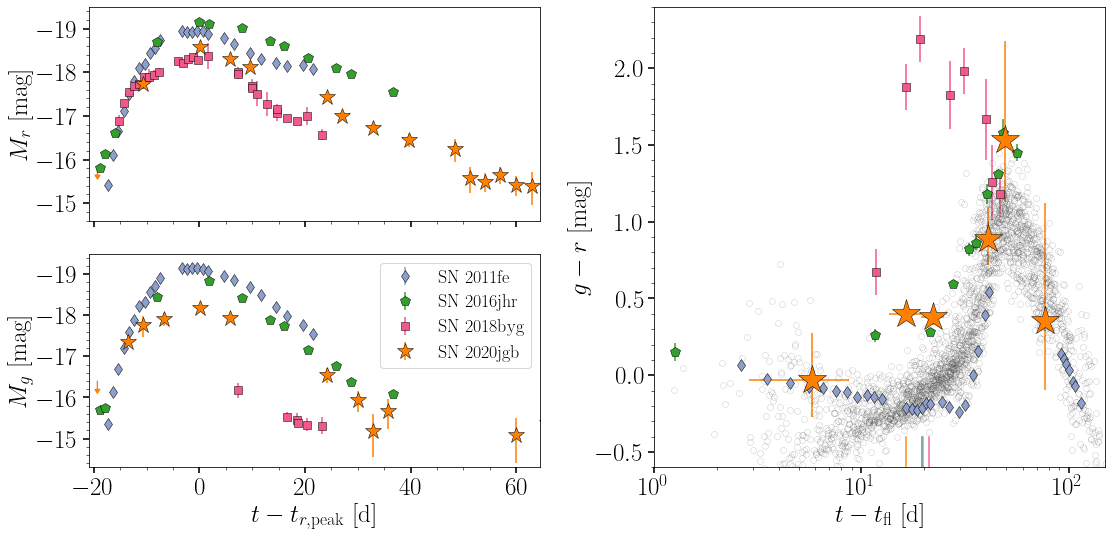

In [26]:
f = plt.figure(figsize=(16, 8))
ax2 = plt.subplot(2, 2, 1)
ax1 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(1, 2, 2)

col_11fe = color_map['blue']
col_16jhr = color_map['green']
col_18byg = color_map['magenta']
col_20jgb = color_map['orange']

# light curves
#11fe
ax1.errorbar(fe_g_syn[:, 0],
             fe_g_syn[:, 1],
             yerr=fe_g_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe,
             label='$\mathrm{SN\ 2011fe}$')
ax2.errorbar(fe_r_syn[:, 0],
             fe_r_syn[:, 1],
             yerr=fe_r_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)

#16jhr
ax1.errorbar(jhr_g_bin[:, 0],
             jhr_g_bin[:, 1],
             yerr=jhr_g_bin[:, 2],
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr,
             label='$\mathrm{SN\ 2016jhr}$')
ax2.errorbar(jhr_r_bin[:, 0],
             jhr_r_bin[:, 1],
             yerr=jhr_r_bin[:, 2],
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr)

#18 byg
ax1.errorbar(byg_g['Phase'],
             byg_g['Mag'],
             yerr=byg_g['e_omag'],
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg,
             label='$\mathrm{SN\ 2018byg}$')
ax2.errorbar(byg_r['Phase'],
             byg_r['Mag'],
             yerr=byg_r['e_omag'],
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)

X2 = np.loadtxt('./20jgb_phot/SN2020jgb_ZTF_g_snr2.dat')
Y2 = np.loadtxt('./20jgb_phot/SN2020jgb_ZTF_r_snr2.dat')

dT, dmag, Unc = mag1_mag2(X2, Y2, bin_size=1, flux=True)
Mag_pred, Mag_pred_unc = [], []
for x2, ax in zip([X2, Y2], [ax1, ax2]):
    t = x2[x2[:, 2] > 0, 0]
    mag = x2[x2[:, 2] > 0, 1].copy()
    mag_unc = x2[x2[:, 2] > 0, 3:].T.copy()
    t_lim = x2[x2[:, 2] < 0, 0].copy()
    lim = x2[x2[:, 2] < 0, 1].copy()

    # last non-detection
    first_det = np.argwhere(x2[:, 2] > 0).ravel()[0]
    ax.arrow(x=(x2[first_det - 1,0] - tp) / (1 + z),
             y=x2[first_det - 1,1] - 0.3,
             dx=0,
             dy=0.3,
             width=0.06,
             head_width=1,
             head_length=0.1,
             length_includes_head=True,
             color=col_20jgb)

    ax.errorbar((t - tp) / (1 + z),
                mag,
                yerr=mag_unc,
                fmt='*',
                markersize=17,
                markeredgecolor='k',
                markeredgewidth=.5,
                color=col_20jgb,
                label='$\mathrm{SN\ 2020jgb}$')

    ax.set_xlim(-21, 64.5)
    ax.set_yticks([-15, -16, -17, -18, -19])

ax2.xaxis.set_ticklabels([])
ax2.set_ylabel(r'$M_r\ \mathrm{[mag]}$')

ax1.legend(prop={'size': 18})
ax1.set_xlabel(r'$t-t_{r,\mathrm{peak}}\ [\mathrm{d}]$')
ax1.set_ylabel(r'$M_g\ \mathrm{[mag]}$')

ax2.set_ylim(-19.5, -14.6)
ax1.set_ylim(-19.5, -14.3)
ax1.invert_yaxis()
ax2.invert_yaxis()

# g-r color
# the four individuals
ax3.errorbar(fe_g_r_syn[:, 0],
             fe_g_r_syn[:, 1],
             yerr=fe_g_r_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)
ax3.errorbar(dT_jhr,
             dmag_jhr,
             yerr=Unc_jhr,
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr)
ax3.errorbar(dT_byg,
             dmag_byg,
             yerr=Unc_byg,
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)
ax3.errorbar((dT - tfl) / (1 + z),
             dmag,
             xerr=tfl_unc / (1 + z),
             yerr=Unc,
             fmt='*',
             markersize=30,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_20jgb)

# peak time
ax3.plot([(tp - tfl) / (1 + z), (tp - tfl) / (1 + z)], [-0.7, -0.4],
         color=col_20jgb,
         alpha=.9,
         zorder=-10)
ax3.plot([(tp_byg - tfl_byg) / (1 + z_byg), (tp_byg - tfl_byg) / (1 + z_byg)],
         [-0.7, -0.4],
         color=col_18byg,
         alpha=.9,
         zorder=-10)
ax3.plot([(57504 - 57482) / (1 + 0.11737), (57504 - 57482) / (1 + 0.11737)],
         [-0.7, -0.4],
         color=col_16jhr,
         alpha=.9,
         zorder=-10)
ax3.plot([(55816.6 - 55796.687) / (1 + 0.0008),
          (55816.6 - 55796.687) / (1 + 0.0008)], [-0.7, -0.4],
         color=col_11fe,
         alpha=.9,
         zorder=-10)

# ZTF sample
# K-corrections
'''ax3.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=6,
         alpha=0.3)'''

# No K-corrections
ebv_sbv = pd.read_csv('./color/early18ia/ebv_sbv.txt', sep=' ')
lcs = glob.glob('./color/early18ia/*dat')
lcs.sort()
t_tfl_list = fits.getdata('./color/Bulla20.fit')

for lc in lcs:
    name = lc.split('/')[-1].split('.')[0]
    if name in gr_population.iloc[normal_ia].SN.unique():
        t_tfl = t_tfl_list['t-tfl'][t_tfl_list['ZTF'] == name]
        raw = pd.read_csv(lc, sep=' ')
        lc_g0 = np.array(raw)[:, :-1][raw['fid'] ==
                                      1]  # determine the first detection
        lc_r0 = np.array(raw)[:, :-1][raw['fid'] == 2]
        lc_g = np.array(raw)[:, :-1][(raw['fid'] == 1) &
                                     (raw['mag_unc'] < 0.2)]  # SNR > 5
        lc_r = np.array(raw)[:, :-1][(raw['fid'] == 2)
                                     & (raw['mag_unc'] < 0.2)]
        g_r0 = mag1_mag2(lc_g0, lc_r0)
        g_r = mag1_mag2(lc_g, lc_r)
        t_offset = t_tfl - g_r0[0][0]
        ebv = np.array(ebv_sbv['ebv'])[ebv_sbv['sn'] == name][0]
        ax3.plot(g_r[0] + t_offset,
                 g_r[1] - (calALambda(wv=leff_g, EBV=ebv, RV=3.1) -
                           calALambda(wv=leff_r, EBV=ebv, RV=3.1)),
                 'o',
                 color='None',
                 mec='0.2',
                 mew=0.4,
                 ms=6,
                 alpha=0.3)

ax3.set_ylim(-0.6, 2.4)
ax3.set_xlim(1, 150)
ax3.set_ylabel('$g-r\ \mathrm{[mag]}$')
ax3.set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax3.set_xscale('log')

for ax in [ax1, ax2]:
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.savefig('../paper/figures/photometry.pdf', bbox_inches='tight')

In [13]:
def decline_rate(data, post=20):
    t = data[:, 0]
    mag = data[:, 1]
    tp = t[np.argmin(mag)]
    magp = np.min(mag)
    ref = np.argmin(np.abs(t - tp - post))
    rate = (mag[ref] - magp) / (t[ref] - tp)
    print(
        'closest obs: {:.2f}, rate: {:.3f} mag/d, Delta M{:.0f}: {:.2f}'.format(
            t[ref] - tp, rate, post, rate * post))

In [14]:
decline_rate(fe_g_syn)
decline_rate(jhr_g_bin)
decline_rate(np.array([byg_g['Phase'], byg_g['Mag']]).T, post=12)
decline_rate(X2) #20jgb

closest obs: 19.98, rate: 0.058 mag/d, Delta M20: 1.16
closest obs: 18.79, rate: 0.089 mag/d, Delta M20: 1.79
closest obs: 11.29, rate: 0.070 mag/d, Delta M12: 0.84
closest obs: 24.88, rate: 0.066 mag/d, Delta M20: 1.32


In [15]:
decline_rate(fe_g_syn, post=-14)
decline_rate(jhr_g_bin, post=-14)
decline_rate(X2, post=-14) #20jgb

closest obs: -13.89, rate: -0.274 mag/d, Delta M-14: 3.83
closest obs: -9.84, rate: -0.041 mag/d, Delta M-14: 0.57
closest obs: -13.95, rate: -0.060 mag/d, Delta M-14: 0.84
